In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Islamophhobia Detection with BERT using Keras and TensorFlow 2

In [3]:
!nvidia-smi

Sun Sep 20 17:29:24 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    38W / 300W |   1951MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
!pip install tensorflow-gpu 

     |████████████████████████████████| 320.4MB 44kB/s 


In [5]:
!pip install --upgrade grpcio

Requirement already up-to-date: grpcio in /usr/local/lib/python3.6/dist-packages (1.32.0)


In [6]:
!pip install tqdm

In [7]:
!pip install bert-for-tf2

     |████████████████████████████████| 40kB 3.7MB/s 
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.6-cp36-none-any.whl size=30318 sha256=f7d0087ba6dad0479b16782c0a75d06cacb0d913289da894f16593132dd02fb6
  Stored in directory: /root/.cache/pip/wheels/07/a0/b4/75b0601ebaa41e517a797fe9cea119c789664c8408f8a74ae9
  Created wheel for py-params: filename=py_params-0.9.7-cp36-none-any.whl size=7304 sha256=ecd8fed526fc0c03998579198c230ca9ddc5839fb1dee6f172ddbacffcd2c3d5
  Stored in directory: /root/.cache/pip/wheels/67/f5/19/b461849a50aefdf4bab47c4756596e82ee2118b8278e5a1980
  Created wheel for params-flow: filename=params_flow-0.8.2-cp36-none-any.whl size=19475 sha256=108d974b55978c4a060934ebc7045a0f86cc9851b0c52619cfd99613c8dc85a7
  Stored in directory: /root/.cache/pip/wheels/08/c8/7f/81c86b9ff2b86e2c477e3914175be03e679e596067dc630c06
Successfully built bert-for-tf2 py-params params-flow


In [8]:
!pip install googletrans

     |████████████████████████████████| 61kB 5.5MB/s 
     |████████████████████████████████| 51kB 5.8MB/s 
     |████████████████████████████████| 962kB 9.0MB/s 
     |████████████████████████████████| 71kB 8.5MB/s 
     |████████████████████████████████| 61kB 8.1MB/s 
     |████████████████████████████████| 102kB 9.2MB/s 
  Created wheel for googletrans: filename=googletrans-3.0.0-cp36-none-any.whl size=15736 sha256=b03463817958279fcc498aef91fd44bd185d1489616d908b1fdb37d39a4bfd9d
  Stored in directory: /root/.cache/pip/wheels/28/1a/a7/eaf4d7a3417a0c65796c547cff4deb6d79c7d14c2abd29273e
  Created wheel for contextvars: filename=contextvars-2.4-cp36-none-any.whl size=7666 sha256=12157386d4e83914ec2abed4f8cc28e8e11379d71b67414f115287f46f59d0b2
  Stored in directory: /root/.cache/pip/wheels/a5/7d/68/1ebae2668bda2228686e3c1cf16f2c2384cea6e9334ad5f6de
Successfully built googletrans contextvars


In [9]:
!pip install sentencepiece

     |████████████████████████████████| 1.1MB 8.6MB/s 


In [10]:
!pip install googletrans

In [11]:
import os
import math
import datetime

from tqdm import tqdm

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras

import bert
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc

from sklearn.metrics import confusion_matrix, classification_report

import re

# translator
import googletrans
from googletrans import Translator

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Data


In [12]:
# Hindi data
!gdown --id 1EQRLvSUJn6VxFluTqNEGxXcV8_5OmCaW --output data-task3.csv

Downloading...
From: https://drive.google.com/uc?id=1EQRLvSUJn6VxFluTqNEGxXcV8_5OmCaW
To: /content/data-task3.csv
100% 1.63M/1.63M [00:00<00:00, 110MB/s]


In [13]:
df = pd.read_csv('data-task3.csv', 
                   delimiter=',')
df.columns = ['Text', 'Label']
df.head(15)
df["Text"] = df["Text"].astype(str)
df["Label"] = df["Label"].astype(str)

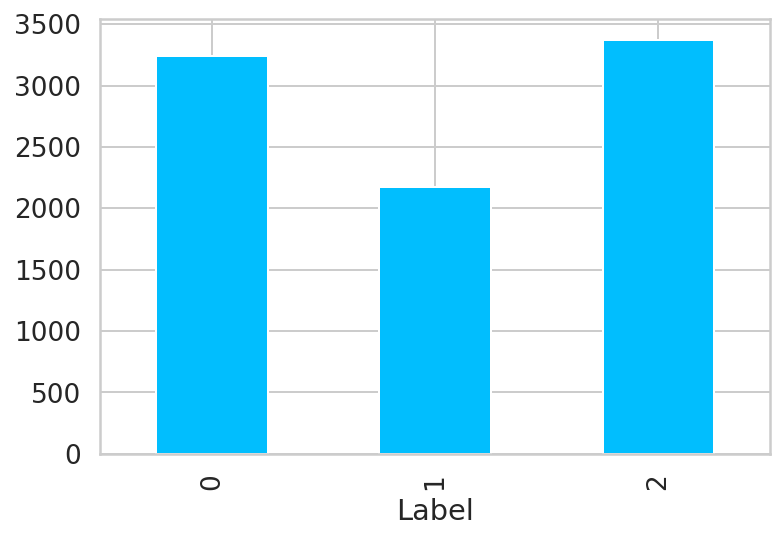

In [14]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(6,4))
df.groupby('Label').Text.count().plot.bar(ylim=0)
plt.show()

In [15]:

# For entire dataset sentences for each labels 
df.Label.value_counts()

2    3375
0    3244
1    2174
Name: Label, dtype: int64

In [16]:
df=df.sample(frac=1).reset_index(drop=True)
df

,Text,Label
0,'सुम्मा आमीन 💐💐💐💐 #डॉक्टर_कफील_की_रिहाई_मुबार...,1
1,'@RajkumarRatnap2 सहमत हूँ आपसे सर जी । रावण औ...,2
2,'@Munnasaifi @sardanarohit बेंगलुरु में आग किस...,2
3,'जो इस्लाम वज़ू में जायदा पानी बहाने का इजाजत...,0
4,'@GeoIntel2 दीवाली पे मिलो खींच खींच के बाल त...,0
...,...,...
8788,'तस्वीरों में देखें कैसे रांची के राजकुमार बन...,0
8789,'@ZeeNewsHindi हज़ारों मुसलमानों ने रमज़ान में...,1
8790,'@chandan_m_yadav @RustamPatel3 @nidhiyadavsp ...,0
8791,'@AbdullahJlp अल्लाह हाफ़िज़ भाई मेरे,1


Data Preprocessing

In [17]:
df = df[df.Text != '']

In [18]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.10, random_state=42)

In [19]:
df.head()

,Text,Label
0,'सुम्मा आमीन 💐💐💐💐 #डॉक्टर_कफील_की_रिहाई_मुबार...,1
1,'@RajkumarRatnap2 सहमत हूँ आपसे सर जी । रावण औ...,2
2,'@Munnasaifi @sardanarohit बेंगलुरु में आग किस...,2
3,'जो इस्लाम वज़ू में जायदा पानी बहाने का इजाजत...,0
4,'@GeoIntel2 दीवाली पे मिलो खींच खींच के बाल त...,0


# Islamophhobia Detection with BERT


In [20]:
!wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip

--2020-09-20 17:30:29--  https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.218.128, 173.194.79.128, 108.177.119.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.218.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407727028 (389M) [application/zip]
Saving to: ‘uncased_L-12_H-768_A-12.zip’

uncased_L-12_H-768_ 100%[===================>] 388.84M   112MB/s    in 3.5s    

2020-09-20 17:30:33 (112 MB/s) - ‘uncased_L-12_H-768_A-12.zip’ saved [407727028/407727028]



In [21]:
!unzip uncased_L-12_H-768_A-12.zip

Archive:  uncased_L-12_H-768_A-12.zip
   creating: uncased_L-12_H-768_A-12/
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.meta  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001  
  inflating: uncased_L-12_H-768_A-12/vocab.txt  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.index  
  inflating: uncased_L-12_H-768_A-12/bert_config.json  


In [22]:
os.makedirs("model", exist_ok=True)

In [23]:
!mv uncased_L-12_H-768_A-12/ model

In [24]:
bert_model_name="uncased_L-12_H-768_A-12"

bert_ckpt_dir = os.path.join("model/", bert_model_name)
bert_ckpt_file = os.path.join(bert_ckpt_dir, "bert_model.ckpt")
bert_config_file = os.path.join(bert_ckpt_dir, "bert_config.json")

## Preprocessing

In [25]:
class IslamophobiaDetectionData:
  DATA_COLUMN = "Text"
  LABEL_COLUMN = "Label"

  def __init__(self, train, test, tokenizer: FullTokenizer, classes, max_seq_len=192):
    self.tokenizer = tokenizer
    self.max_seq_len = 0
    self.classes = classes
    
    ((self.train_x, self.train_y), (self.test_x, self.test_y)) = map(self._prepare, [train, test])

    print("max seq_len", self.max_seq_len)
    self.max_seq_len = min(self.max_seq_len, max_seq_len)
    self.train_x, self.test_x = map(self._pad, [self.train_x, self.test_x])

  def _prepare(self, df):
    x, y = [], []
    
    for _, row in tqdm(df.iterrows()):
      text, label = row[IslamophobiaDetectionData.DATA_COLUMN], row[IslamophobiaDetectionData.LABEL_COLUMN]
      tokens = self.tokenizer.tokenize(text)
      tokens = ["[CLS]"] + tokens + ["[SEP]"]
      token_ids = self.tokenizer.convert_tokens_to_ids(tokens)
      self.max_seq_len = max(self.max_seq_len, len(token_ids))
      x.append(token_ids)
      y.append(self.classes.index(label))

    return np.array(x), np.array(y)

  def _pad(self, ids):
    x = []
    for input_ids in ids:
      input_ids = input_ids[:min(len(input_ids), self.max_seq_len - 2)]
      input_ids = input_ids + [0] * (self.max_seq_len - len(input_ids))
      x.append(np.array(input_ids))
    return np.array(x)

In [26]:
tokenizer = FullTokenizer(vocab_file=os.path.join(bert_ckpt_dir, "vocab.txt"))

In [27]:
def create_model(max_seq_len, bert_ckpt_file):

  with tf.io.gfile.GFile(bert_config_file, "r") as reader:
      bc = StockBertConfig.from_json_string(reader.read())
      bert_params = map_stock_config_to_params(bc)
      bert_params.adapter_size = None
      bert = BertModelLayer.from_params(bert_params, name="bert")
        
  input_ids = keras.layers.Input(shape=(max_seq_len, ), dtype='int32', name="input_ids")
  bert_output = bert(input_ids)

  #print("bert shape", bert_output.shape)

  cls_out = keras.layers.Lambda(lambda seq: seq[:, 0, :])(bert_output)
  cls_out = keras.layers.Dropout(0.5)(cls_out)
  logits = keras.layers.Dense(units=768, activation="tanh")(cls_out)
  logits = keras.layers.Dropout(0.5)(logits)

  logits = keras.layers.Dense(units=len(classes), activation="softmax")(logits)


  model = keras.Model(inputs=input_ids, outputs=logits)
  model.build(input_shape=(None, max_seq_len))

  load_stock_weights(bert, bert_ckpt_file)
  
  model.compile(
  optimizer=keras.optimizers.Adam(1e-5),
  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
)
        
  return model

## Training

In [28]:
classes = train.Label.unique().tolist()

data = IslamophobiaDetectionData(train, test, tokenizer, classes, max_seq_len=128)

7913it [00:04, 1911.73it/s]
880it [00:00, 1969.10it/s]


max seq_len 225


In [29]:
model = create_model(data.max_seq_len, bert_ckpt_file)

Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7fa6e3d45438> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights


In [30]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 128)]             0         
_________________________________________________________________
bert (BertModelLayer)        (None, 128, 768)          108890112 
_________________________________________________________________
lambda (Lambda)              (None, 768)               0         
_________________________________________________________________
dropout (Dropout)            (None, 768)               0         
_________________________________________________________________
dense (Dense)                (None, 768)               590592    
_________________________________________________________________
dropout_1 (Dropout)          (None, 768)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                

In [31]:
history = model.fit(
  x=data.train_x, 
  y=data.train_y,
  validation_split=0.1,
  batch_size=16,
  shuffle=True,
  epochs=5
)

Epoch 1/5
446/446 [==============================] - 119s 266ms/step - loss: 0.8680 - acc: 0.6623 - val_loss: 0.6314 - val_acc: 0.9129
Epoch 2/5
446/446 [==============================] - 118s 264ms/step - loss: 0.6258 - acc: 0.9257 - val_loss: 0.6226 - val_acc: 0.9280
Epoch 3/5
446/446 [==============================] - 117s 263ms/step - loss: 0.6172 - acc: 0.9337 - val_loss: 0.6196 - val_acc: 0.9331
Epoch 4/5
446/446 [==============================] - 117s 262ms/step - loss: 0.6128 - acc: 0.9376 - val_loss: 0.6271 - val_acc: 0.9242
Epoch 5/5
446/446 [==============================] - 117s 261ms/step - loss: 0.6085 - acc: 0.9420 - val_loss: 0.6213 - val_acc: 0.9306


## Evaluation

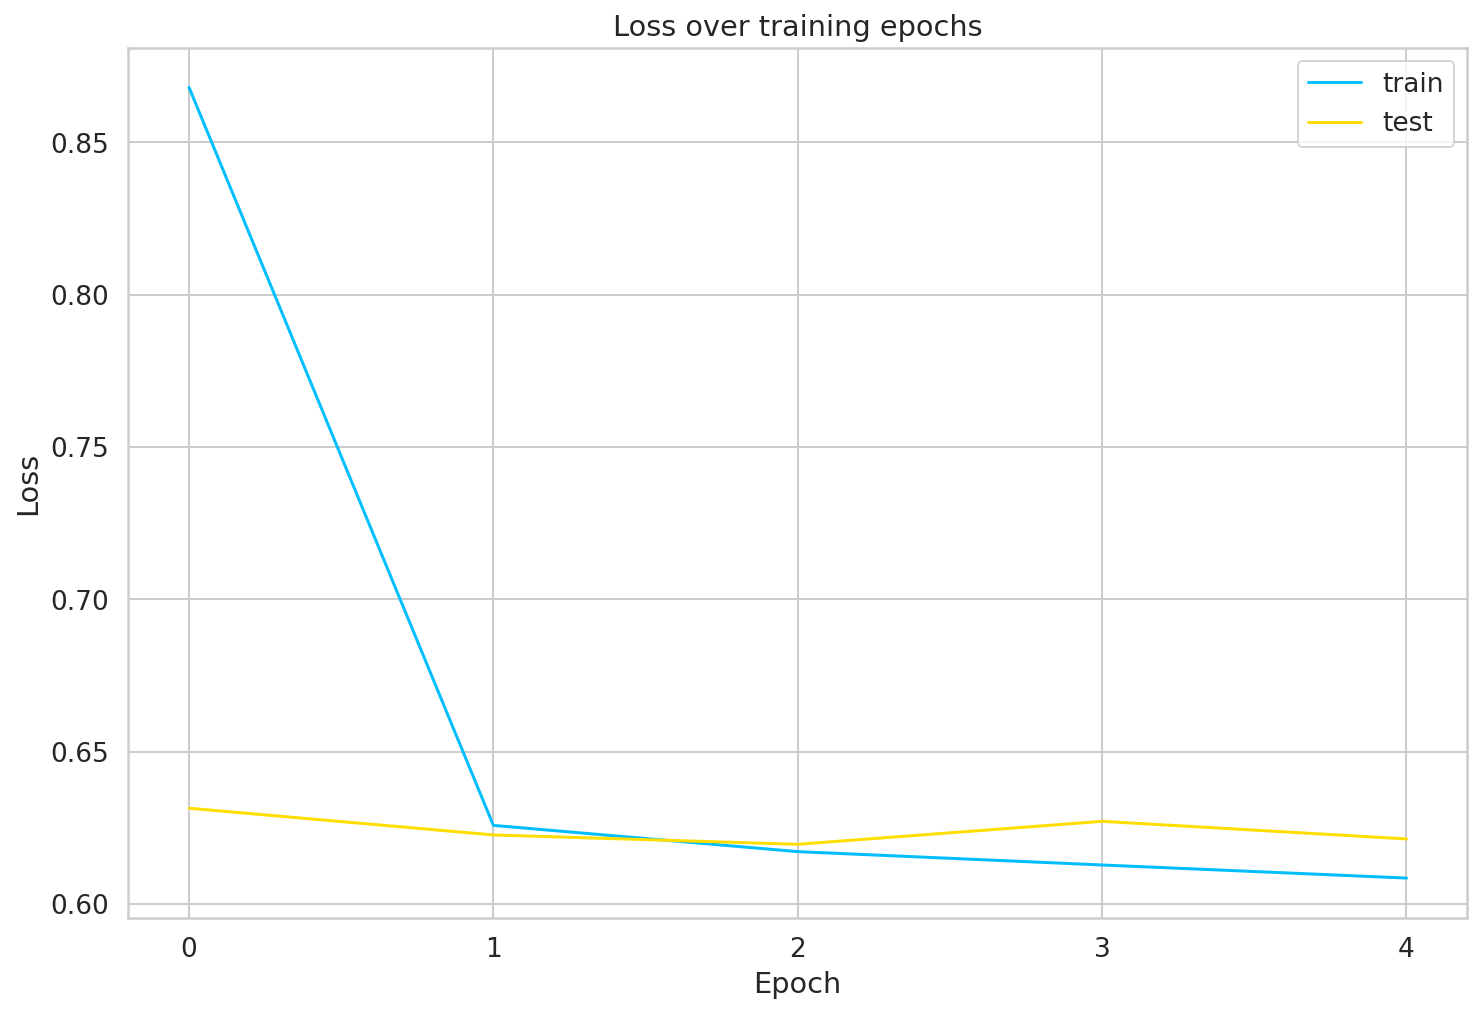

In [32]:
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

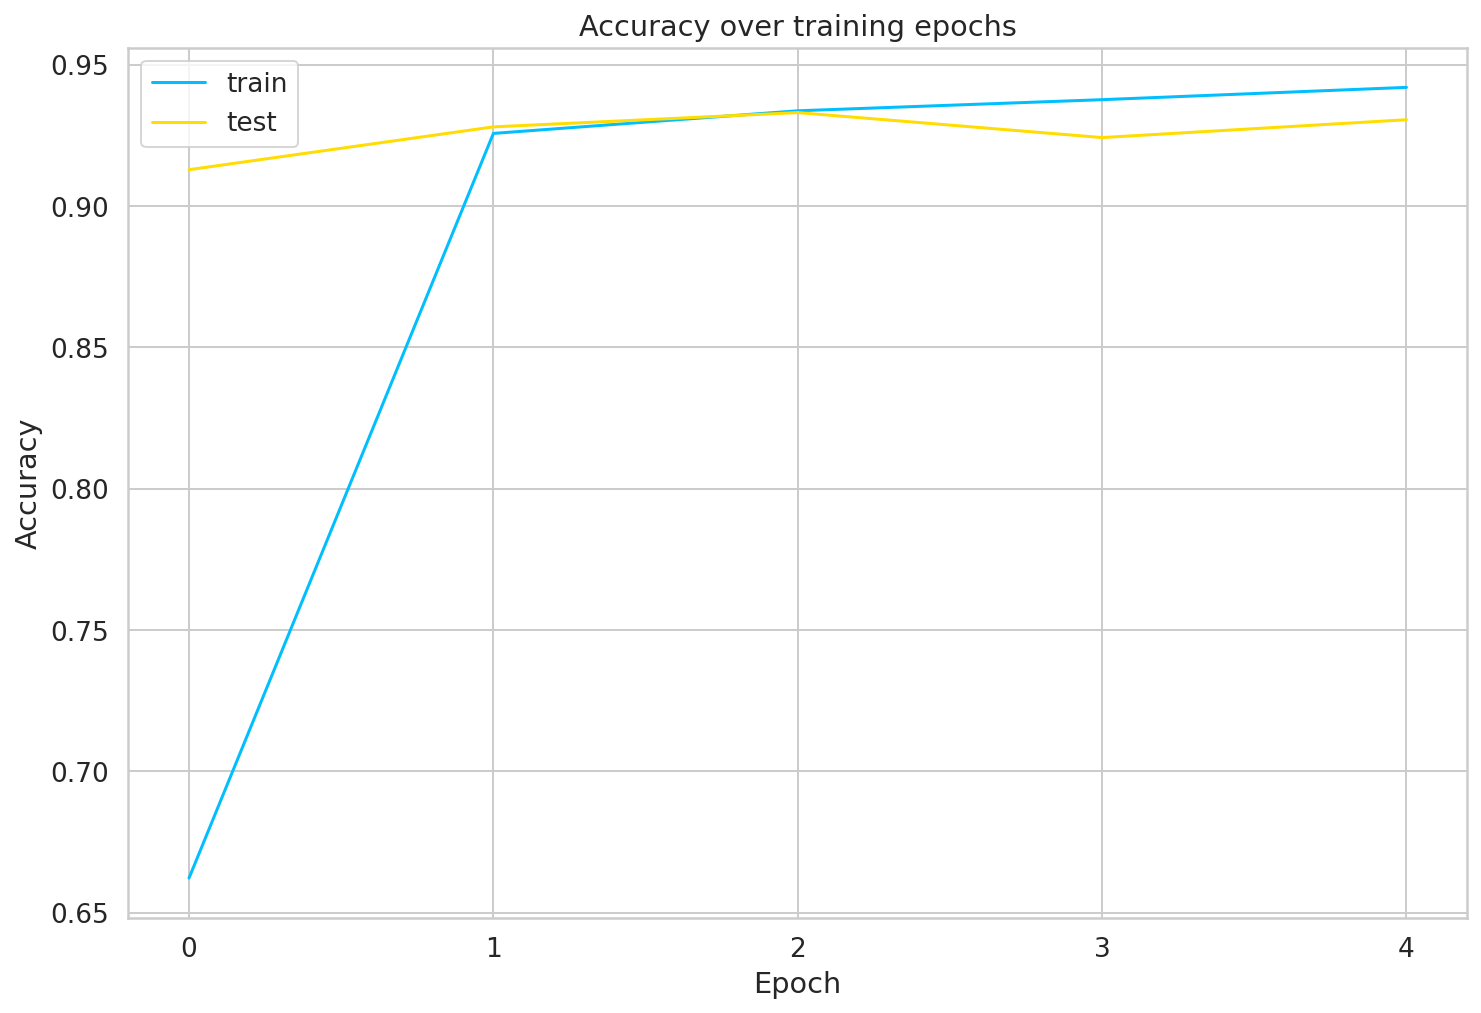

In [33]:
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.plot(history.history['acc'])
ax.plot(history.history['val_acc'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Accuracy over training epochs')
plt.show();

In [34]:
_, train_acc = model.evaluate(data.train_x, data.train_y)
_, test_acc = model.evaluate(data.test_x, data.test_y)

print("train acc", train_acc)
print("test acc", test_acc)

28/28 [==============================] - 3s 103ms/step - loss: 0.6249 - acc: 0.9261
train acc 0.9418678283691406
test acc 0.9261363744735718


In [35]:
y_pred = model.predict(data.test_x).argmax(axis=-1)

In [36]:
print(classification_report(data.test_y, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.97      0.93       327
           1       0.97      0.89      0.93       336
           2       0.91      0.91      0.91       217

    accuracy                           0.93       880
   macro avg       0.93      0.92      0.92       880
weighted avg       0.93      0.93      0.93       880



In [37]:

cm = confusion_matrix(data.test_y, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)

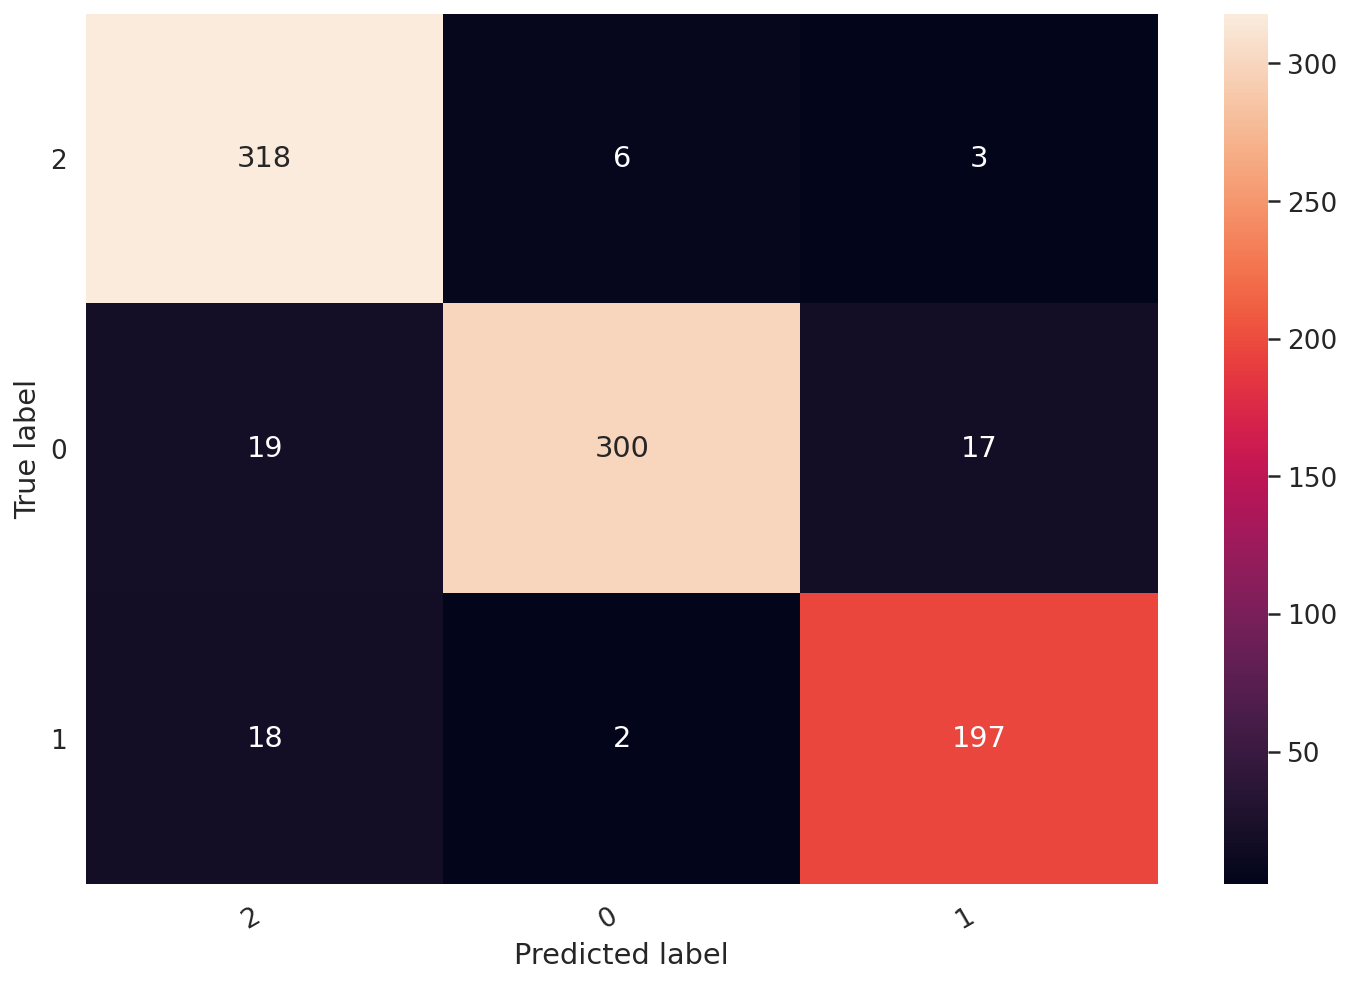

In [38]:
hmap = sns.heatmap(df_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

# 10 Fold cross validation

In [39]:
import random
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

kFold = 10

#To get accuracy of the model for 10 different splits
scores = []
training_accuracy = []
testing_accuracy = []
print("BERT: ")
for i in range(kFold):
    print('Fold ', i+1)
    print('')
    # Splitting data into test and train
    train, test = train_test_split(df, test_size=0.10, shuffle = True)

    classes = train.Label.unique().tolist()
    data = IslamophobiaDetectionData(train, test, tokenizer, classes, max_seq_len=128)
    model = create_model(data.max_seq_len, bert_ckpt_file)
    history = model.fit( x=data.train_x, y=data.train_y,validation_split=0.1,batch_size=16, shuffle=True,epochs=5)
    #train_loss, train_acc = model.evaluate(data.train_x, data.train_y)
    test_loss, test_acc = model.evaluate(data.test_x, data.test_y)
    
    #training_accuracy.append(train_acc)
    testing_accuracy.append(test_acc)

    y_pred = model.predict(data.test_x).argmax(axis=-1)

    scoreValue =accuracy_score(data.test_y, y_pred)
    scores.append(scoreValue)


202it [00:00, 2008.14it/s]

BERT: 
Fold  1



7913it [00:03, 2069.06it/s]
880it [00:00, 2050.24it/s]


max seq_len 225
Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7fa5e5f342e8> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
446/446 [==============================] - 118s 264ms/step - loss: 0.8688 - acc: 0.6579 - val_loss: 0.6144 - val_acc: 0.9331
Epoch 2/5
446/446 [==============================] - 113s 252ms/step - loss: 0.6227 - acc: 0.9285 - val_loss: 0.6094 - val_acc: 0.9419
Epoch 3/5
446/446 [==============================] - 112s 251ms/step - loss

224it [00:00, 2239.57it/s]

Fold  2



7913it [00:03, 2167.59it/s]
880it [00:00, 2143.45it/s]


max seq_len 225
Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7fa4d9bfbc50> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
446/446 [==============================] - 115s 259ms/step - loss: 0.8884 - acc: 0.6288 - val_loss: 0.6392 - val_acc: 0.9129
Epoch 2/5
446/446 [==============================] - 112s 251ms/step - loss: 0.6248 - acc: 0.9260 - val_loss: 0.6323 - val_acc: 0.9179
Epoch 3/5
446/446 [==============================] - 112s 250ms/step - loss

213it [00:00, 2121.49it/s]

Fold  3



7913it [00:03, 2148.01it/s]
880it [00:00, 2130.05it/s]


max seq_len 225
Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7fa5e5deabe0> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
446/446 [==============================] - 118s 265ms/step - loss: 0.9795 - acc: 0.5244 - val_loss: 0.6729 - val_acc: 0.8775
Epoch 2/5
446/446 [==============================] - 115s 258ms/step - loss: 0.6394 - acc: 0.9120 - val_loss: 0.6161 - val_acc: 0.9343
Epoch 3/5
446/446 [==============================] - 115s 257ms/step - loss

225it [00:00, 2246.82it/s]

Fold  4



7913it [00:03, 2168.33it/s]
880it [00:00, 2179.05it/s]


max seq_len 225
Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7fa5e5dc22b0> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
446/446 [==============================] - 118s 265ms/step - loss: 0.8865 - acc: 0.6367 - val_loss: 0.6371 - val_acc: 0.9154
Epoch 2/5
446/446 [==============================] - 116s 259ms/step - loss: 0.6331 - acc: 0.9170 - val_loss: 0.6250 - val_acc: 0.9255
Epoch 3/5
446/446 [==============================] - 115s 258ms/step - loss

215it [00:00, 2144.84it/s]

Fold  5



7913it [00:03, 2104.93it/s]
880it [00:00, 2070.12it/s]


max seq_len 225
Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7fa5dc992c18> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
446/446 [==============================] - 118s 264ms/step - loss: 0.8884 - acc: 0.6381 - val_loss: 0.6441 - val_acc: 0.9066
Epoch 2/5
446/446 [==============================] - 115s 258ms/step - loss: 0.6292 - acc: 0.9226 - val_loss: 0.6179 - val_acc: 0.9331
Epoch 3/5
446/446 [==============================] - 115s 257ms/step - loss

213it [00:00, 2128.00it/s]

Fold  6



7913it [00:03, 2221.37it/s]
880it [00:00, 2163.52it/s]


max seq_len 225
Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7fa5dc4c75f8> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
446/446 [==============================] - 117s 262ms/step - loss: 0.8762 - acc: 0.6464 - val_loss: 0.6394 - val_acc: 0.9104
Epoch 2/5
446/446 [==============================] - 113s 254ms/step - loss: 0.6277 - acc: 0.9237 - val_loss: 0.6179 - val_acc: 0.9343
Epoch 3/5
446/446 [==============================] - 113s 254ms/step - loss

234it [00:00, 2328.63it/s]

Fold  7



7913it [00:03, 2249.31it/s]
880it [00:00, 2246.67it/s]


max seq_len 225
Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7fa5dc7a2fd0> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
446/446 [==============================] - 116s 260ms/step - loss: 0.8522 - acc: 0.6763 - val_loss: 0.6154 - val_acc: 0.9343
Epoch 2/5
446/446 [==============================] - 113s 254ms/step - loss: 0.6230 - acc: 0.9282 - val_loss: 0.6390 - val_acc: 0.9066
Epoch 3/5
446/446 [==============================] - 113s 252ms/step - loss

232it [00:00, 2317.46it/s]

Fold  8



7913it [00:03, 2265.67it/s]
880it [00:00, 2221.23it/s]


max seq_len 225
Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7fa5dc443a20> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
446/446 [==============================] - 117s 262ms/step - loss: 0.9359 - acc: 0.5818 - val_loss: 0.6205 - val_acc: 0.9306
Epoch 2/5
446/446 [==============================] - 114s 255ms/step - loss: 0.6311 - acc: 0.9211 - val_loss: 0.6160 - val_acc: 0.9356
Epoch 3/5
446/446 [==============================] - 114s 256ms/step - loss

221it [00:00, 2201.81it/s]

Fold  9



7913it [00:03, 2244.83it/s]
880it [00:00, 2246.65it/s]


max seq_len 225
Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7fa6e1adbe10> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
446/446 [==============================] - 115s 258ms/step - loss: 0.9263 - acc: 0.5912 - val_loss: 0.6604 - val_acc: 0.8902
Epoch 2/5
446/446 [==============================] - 112s 252ms/step - loss: 0.6308 - acc: 0.9208 - val_loss: 0.6174 - val_acc: 0.9343
Epoch 3/5
446/446 [==============================] - 113s 253ms/step - loss

230it [00:00, 2288.74it/s]

Fold  10



7913it [00:03, 2227.08it/s]
880it [00:00, 2272.24it/s]


max seq_len 225
Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7fa5dd71d358> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
446/446 [==============================] - 116s 259ms/step - loss: 0.8842 - acc: 0.6364 - val_loss: 0.6198 - val_acc: 0.9318
Epoch 2/5
446/446 [==============================] - 113s 254ms/step - loss: 0.6324 - acc: 0.9183 - val_loss: 0.6158 - val_acc: 0.9356
Epoch 3/5
446/446 [==============================] - 114s 255ms/step - loss

In [42]:

print('')
Mean_score = sum(scores) / len(scores)
print(f" Mean predict: {Mean_score}" )

mean_test = sum(testing_accuracy)/len(testing_accuracy)
print(f" Mean testing accuracy for 10 folds: {mean_test}" )


 Mean predict: 0.9349999999999999
 Mean testing accuracy for 10 folds: 0.9350000023841858


In [43]:
translator = Translator()
sentences = []
# 1
hin_text =  "इसलाम सुंदर है"
sentences.append(hin_text)

trans = translator.translate(hin_text, dest='en')
sentences.append(trans.text)

# 0
hin_text =  " समाज वादी  पार्टी  जिंदाबाद "
sentences.append(hin_text)

trans = translator.translate(hin_text, dest='en')
sentences.append(trans.text)

# 2
hin_text =  "'गाजा में दीवाली   की ढेरो बधाई मित्रो 😊💐  #IsraeliBombing 😂😂"
sentences.append(hin_text)

trans = translator.translate(hin_text, dest='en')
sentences.append(trans.text)

# 2
sentences.append( "Play our song now you asshole jehadi muslim")

# 0
sentences.append( "Rate this book as awful")


pred_tokens = map(tokenizer.tokenize, sentences)
pred_tokens = map(lambda tok: ["[CLS]"] + tok + ["[SEP]"], pred_tokens)
pred_token_ids = list(map(tokenizer.convert_tokens_to_ids, pred_tokens))

pred_token_ids = map(lambda tids: tids +[0]*(data.max_seq_len-len(tids)),pred_token_ids)
pred_token_ids = np.array(list(pred_token_ids))

predictions = model.predict(pred_token_ids).argmax(axis=-1)

for text, label in zip(sentences, predictions):
  print("text:", text, "\nLabel:", classes[label])
  print()

text: इसलाम सुंदर है 
Label: 1

text: Islam is beautiful 
Label: 2

text:  समाज वादी  पार्टी  जिंदाबाद  
Label: 0

text: Samajwadi Party Zindabad 
Label: 2

text: 'गाजा में दीवाली   की ढेरो बधाई मित्रो 😊💐  #IsraeliBombing 😂😂 
Label: 0

text: 'Happy Diwali greetings in Gaza Friends 😊💐 #IsraeliBombing 😂😂 
Label: 1

text: Play our song now you asshole jehadi muslim 
Label: 2

text: Rate this book as awful 
Label: 1

